# <center> <font face=timenewroman color=red> DistilBERT Text Classification </center>



This project is about the analysis of tweets about chatgpt, with the goal of performing a Sentiment Analysis using DistilBert algorithms to predict the emotion of a tweet (good, bad or Neutral).
Before feeding the data to the algorithm, the tweets will be deeply cleaned to remove links, hashtags at the end of the sentences and punctuation to allow the algorithms to better understand the text and improve the prediction performance.

I will use DistilBERT to create a text classification model.DistilBert is a smaller version of BERT that is much faster and cheaper.it is possible to reduce the size of a BERT model by 40%, while retaining 97% of its language understanding capabilities and being 60% faster.

## <center> <font face=timenewroman color=red> Link To Google Drive </center>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## <center> <font face=timenewroman color=red> Importing required librarys </center>

In [ ]:
# %%capture
# ! pip install -U accelerate
# ! pip install -U transformers

In [2]:
%%capture
!pip install transformers

In [3]:
#Importing required librarys

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


In [ ]:
# import transformers
# print('transformers version :', transformers.__version__)

In [4]:
#Loading the dataset

df = pd.read_csv("/content/drive/MyDrive/nlp-project/Dataset/file.csv")
df = df.drop([df.columns[0]], axis=1)
df.values[:5].tolist()

[['ChatGPT: Optimizing Language Models for Dialogue https://t.co/K9rKRygYyn @OpenAI',
  'neutral'],
 ['Try talking with ChatGPT, our new AI system which is optimized for dialogue. Your feedback will help us improve it. https://t.co/sHDm57g3Kr',
  'good'],
 ['ChatGPT: Optimizing Language Models for Dialogue https://t.co/GLEbMoKN6w #AI #MachineLearning #DataScience #ArtificialIntelligence\\n\\nTrending AI/ML Article Identified &amp; Digested via Granola; a Machine-Driven RSS Bot by Ramsey Elbasheer https://t.co/RprmAXUp34',
  'neutral'],
 ['THRILLED to share that ChatGPT, our new model optimized for dialog, is now public, free, and accessible to everyone. https://t.co/dyvtHecYbd https://t.co/DdhzhqhCBX https://t.co/l8qTLure71',
  'good'],
 ['As of 2 minutes ago, @OpenAI released their new ChatGPT. \\n\\nAnd you can use it right now 👇 https://t.co/VyPGPNw988 https://t.co/cSn5h6h1M1',
  'bad']]

In [5]:
df.head()

,tweets,labels
0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,"Try talking with ChatGPT, our new AI system wh...",good
2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,"THRILLED to share that ChatGPT, our new model ...",good
4,"As of 2 minutes ago, @OpenAI released their ne...",bad


## <center> <font face=timenewroman color=red> Drop duplicated values
 </center>

In [6]:
print("Duplicated values: " , df.duplicated().sum())

df.drop_duplicates(inplace=True)
df = df.dropna(axis=0)
print(df.info())

Duplicated values:  1671
<class 'pandas.core.frame.DataFrame'>
Int64Index: 217623 entries, 0 to 219293
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   tweets  217623 non-null  object
 1   labels  217623 non-null  object
dtypes: object(2)
memory usage: 5.0+ MB
None


## <center> <font face=timenewroman color=red> Balancing Data

 </center>

In [7]:
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg') # HD Plots

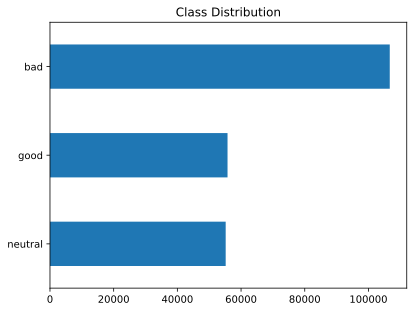

In [8]:
df['labels'].value_counts(ascending=True).plot.barh()
plt.title('Class Distribution')
plt.show()

In [9]:
df["labels"].value_counts()

bad        106695
good        55754
neutral     55174
Name: labels, dtype: int64

In [10]:
class_0 = df[df["labels"] == "neutral"]
class_1 = df[df["labels"] == "good"]
class_neg = df[df["labels"] == "bad"]
class_neg  = class_neg.iloc[:70000]
df = pd.concat([class_neg , class_0 , class_1])

df.head()

,tweets,labels
4,"As of 2 minutes ago, @OpenAI released their ne...",bad
6,"As of 2 minutes ago, @OpenAI released their ne...",bad
10,GOD DAMN IT @OpenAI STOP ANNOUNCING THINGS I A...,bad
17,#ai Models are set to become the search engine...,bad
39,Google is done.\n\nCompare the quality of thes...,bad


In [11]:
df["labels"].value_counts()

bad        70000
good       55754
neutral    55174
Name: labels, dtype: int64

In [ ]:
# df.reset_format()

## <center> <font face=timenewroman color=red> Preprocessing dataset


 </center>

In [12]:
#Cleaning the dataset

import nltk
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer,PorterStemmer

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
st = PorterStemmer()
lem = WordNetLemmatizer()

def is_alpha(word):
    for part in word.split('-'):
        if not part.isalpha():
            return False

    return True

def clean_dataset(text):
    text = re.sub(r'http\S+', '', text) # removing links
    text = re.sub(r'\\n', ' ', text) # removing \\n
    text = re.sub(r"\s*#\S+", "", text) # removing hash tags
    text = re.sub(r"\s*@\S+", "", text) # removing @
    text = text.lower()
    words = [word for word in word_tokenize(text) if is_alpha(word)]
    words = [lem.lemmatize(word) for word in words]
    words = [w for w in words if not w in stop_words]
    text = " ".join(words)

    return text.strip()

df.insert(len(df.columns)-1, "cleaned_tweets", df['tweets'].apply(clean_dataset))
df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,tweets,cleaned_tweets,labels
4,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,bad
6,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,bad
10,GOD DAMN IT @OpenAI STOP ANNOUNCING THINGS I A...,god damn stop announcing thing busy,bad
17,#ai Models are set to become the search engine...,model set become search engine future atm stil...,bad
39,Google is done.\n\nCompare the quality of thes...,google done compare quality response chatgpt,bad


## <center> <font face=timenewroman color=red>WordCloud

 </center>

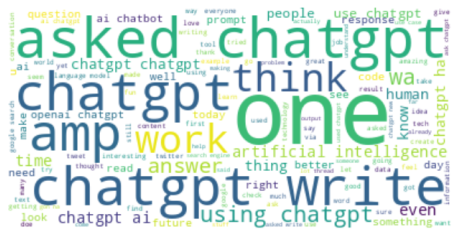

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join([x for x in df.cleaned_tweets])
wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

## <center> <font face=timenewroman color=red>Converting To Numerical

 </center>

In [13]:
#Converting text to numerical form

from numpy.core import numeric
import math
import collections

def convert_text_to_numerical(text):
    num_words = 7000
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    maxlen = 140

    pad_seqs = pad_sequences(sequences, maxlen=maxlen)
    pad_seqs_todrop = []
    for i, p in enumerate(pad_seqs):
        if sum(p) == sum(sorted(p, reverse=True)[0:2]):
            pad_seqs_todrop.append(i)

    return pad_seqs, pad_seqs_todrop, tokenizer, num_words, maxlen

df = df.reset_index()
numeric_tweets, rows_todrop, tokenizer, num_words, maxlen = convert_text_to_numerical(df['cleaned_tweets'])
df.insert(len(df.columns)-1, "numeric_tweets", numeric_tweets.tolist())
df.head()

,index,tweets,cleaned_tweets,numeric_tweets,labels
0,4,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad
1,6,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad
2,10,GOD DAMN IT @OpenAI STOP ANNOUNCING THINGS I A...,god damn stop announcing thing busy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad
3,17,#ai Models are set to become the search engine...,model set become search engine future atm stil...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad
4,39,Google is done.\n\nCompare the quality of thes...,google done compare quality response chatgpt,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad


In [14]:
#Encoding output labels

label_encoder = LabelEncoder()
df.insert(len(df.columns), "encoded_labels", label_encoder.fit_transform(df['labels']))
print(label_encoder.classes_)
df.head()

['bad' 'good' 'neutral']


,index,tweets,cleaned_tweets,numeric_tweets,labels,encoded_labels
0,4,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0
1,6,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0
2,10,GOD DAMN IT @OpenAI STOP ANNOUNCING THINGS I A...,god damn stop announcing thing busy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0
3,17,#ai Models are set to become the search engine...,model set become search engine future atm stil...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0
4,39,Google is done.\n\nCompare the quality of thes...,google done compare quality response chatgpt,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0


In [15]:
final_data = df.drop(rows_todrop, inplace=False)
print(len(df), len(final_data))
final_data.head()

180928 167734


,index,tweets,cleaned_tweets,numeric_tweets,labels,encoded_labels
0,4,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0
1,6,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0
2,10,GOD DAMN IT @OpenAI STOP ANNOUNCING THINGS I A...,god damn stop announcing thing busy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0
3,17,#ai Models are set to become the search engine...,model set become search engine future atm stil...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0
4,39,Google is done.\n\nCompare the quality of thes...,google done compare quality response chatgpt,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0


## <center> <font face=timenewroman color=red>Splitting Data: taining 80% and  testing 20%

 </center>

Since BERT models use the tokenizer directly, we load and process the tokens using the DistilBERT tokenizer. Also, we convert labels to tensor format.

In [16]:
#Split the dataset
inputs = final_data['tweets']
outputs = final_data['encoded_labels']

X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=42)


## <center> <font face=timenewroman color=red> Tokenization
 </center>


In [17]:
#tokens using the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

In [18]:
#Convert text to tokens

def tokenize_text(text):
    return tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        padding='max_length',
        max_length=128,
        pad_to_max_length=True,
        return_attention_mask=True,
        truncation=True,
        return_tensors='pt'
    )

## <center> <font face=timenewroman color=red> Convert texts to tokens and tensors
 </center>

In [19]:
#Tokenization and inputs for training and test data

tokenized_train = [tokenize_text(text) for text in X_train]
tokenized_test = [tokenize_text(text) for text in X_test]

#Creating tensors

train_input_ids = torch.cat([t['input_ids'] for t in tokenized_train])
train_attention_masks = torch.cat([t['attention_mask'] for t in tokenized_train])
train_labels = torch.tensor(y_train.values)

test_input_ids = torch.cat([t['input_ids'] for t in tokenized_test])
test_attention_masks = torch.cat([t['attention_mask'] for t in tokenized_test])
test_labels = torch.tensor(y_test.values)

This step includes loading data, creating tokens using the tokenizer, converting tokens to tensors, and setting labels.

So far, the data has been prepared. In the next steps, we train and predict the DistilBERT model.

## <center> <font face=timenewroman color=red> Training DistilBERT Model
 </center>



In this step, we define and train a DistilBERT model. We also use an auxiliary scheduler to adjust the learning rate:

In [20]:
#Model definition

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# model.cuda()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [21]:
#Define training settings

batch_size = 8
train_data = TensorDataset(train_input_ids, train_attention_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [22]:
#Defining the optimizer model and auxiliary programming to adjust the learning rate

optimizer = AdamW(model.parameters(), lr=1e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [23]:
#Model training
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        batch_input_ids = batch[0].cuda()
        batch_attention_masks = batch[1].cuda()
        batch_labels = batch[2].cuda()

        model.zero_grad()
        outputs = model(batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

    average_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{epochs}, Average Loss: {average_loss:.4f}")

Epoch 1/5, Average Loss: 0.3613
Epoch 2/5, Average Loss: 0.1734
Epoch 3/5, Average Loss: 0.1143
Epoch 4/5, Average Loss: 0.0772
Epoch 5/5, Average Loss: 0.0534


As you can see, the result of loss in 5 epoch seems good and has a downward trend.

## <center> <font face=timenewroman color=red> Test DistilBERT Model
 </center>


Now that the model is trained, we can run it on test data and evaluate the results:

In [24]:
#Definition of evaluation criteria function

def get_measurements(true_y, pred_y, average='micro'):
    return {
        "accuracy": accuracy_score(true_y, pred_y),
        "recall": recall_score(true_y, pred_y, average=average),
        "precision": precision_score(true_y, pred_y, average=average),
        "fscore": f1_score(true_y, pred_y, average=average),
    }

In [25]:
#Define test settings

test_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

model.eval()
predictions = []
with torch.no_grad():
    for batch in test_dataloader:
        batch_input_ids = batch[0].cuda()
        batch_attention_masks = batch[1].cuda()

        outputs = model(batch_input_ids, attention_mask=batch_attention_masks)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, axis=1).cpu().numpy())


#Calculation of evaluation criteria

evaluation_metrics = get_measurements(y_test, predictions)
print("Evaluation Metrics:", evaluation_metrics)


Evaluation Metrics: {'accuracy': 0.951351834739321, 'recall': 0.951351834739321, 'precision': 0.951351834739321, 'fscore': 0.951351834739321}


We are done here. This code covers the steps of training and testing a DistilBERT model on its own data.
In this step, we have run the model on the test data and used the evaluation criteria. And as you can see, we reached 95% accuracy.                                       
Good luck!